In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import time
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
def construct_periodic_kernel(params):
    sigma2 = params[0]
    l = params[1]
    p = params[2]
    kernel = sigma2 * ExpSineSquared(length_scale=l, periodicity=p)
    return kernel

def simulate(n, true_params, initial_params, eps, num_restarts = 1):
    x = np.linspace(start = 0, stop = 1, num = n).reshape(-1, 1)
    shift = np.random.uniform(-1 / (4 * n), 1 / (4 * n), size=n).reshape(-1, 1)
    x = x + shift
    true_kernel = construct_periodic_kernel(true_params) + WhiteKernel(noise_level=eps)
    true_gp = GaussianProcessRegressor(kernel = true_kernel, alpha=0)
    y = np.squeeze(true_gp.sample_y(x, random_state=None))
    #plt.plot(x, y)
    
    kernel = construct_periodic_kernel(initial_params)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=num_restarts, alpha=eps)
    gp.fit(x, y)
    
    gp_params = gp.kernel_.get_params()
    params = [gp_params['k1__constant_value'], 
              gp_params['k2__length_scale'],
              gp_params['k2__periodicity']]
    return params

n = 500
true_params = [1, 1/300, 2]
initial_params = [1 * p for p in true_params]
eps = 0.1
simulate(n, true_params, initial_params, eps, 0)
    

[1.021955135430514, 0.0034073917528728306, 2.0444351076872733]

In [3]:
# Function to generate plots
def get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates):
    # Collect estimates
    estimates = []
    for n in sample_sizes:
        estimates.append([simulate(n, true_params, initial_params, eps, num_restarts) for _ in range(num_replicates)])
    
    param_estimates = [[[est[i] for est in sample] for sample in estimates] for i in range(len(true_params))]
    flattened_estimates = np.array(param_estimates).reshape(len(true_params), -1)  # Flatten the nested list
    np.savetxt('./results/periodic-simulation.txt', flattened_estimates)
    return param_estimates
    
def generate_boxplots(param_estimates, true_params, sample_sizes, param_names):
    # Create boxplots
    fig, axs = plt.subplots(1, len(true_params), figsize=(18, 6))
    for i, param_estimate in enumerate(param_estimates):
        axs[i].boxplot(param_estimate, labels=sample_sizes, vert=True)
        axs[i].axhline(y=true_params[i], color='r', alpha=0.5, linestyle='--')
        axs[i].set_xticks(range(1, len(sample_sizes) + 1))
        axs[i].set_xlabel('Sample Size', fontsize=15)
        axs[i].set_title(f'{param_names[i]}', fontsize=20)

    plt.tight_layout()
    plt.savefig('./boxplots/periodic-simulation.png')
    plt.show()

# Timing execution
start_time = time.time()

# Parameters
num_replicates = 100
true_params = [1,
               1/300,
               4]  # Example true parameters
initial_params = [1.2 * p for p in true_params]
eps = 0.1
num_restarts = 0
sample_sizes = [50, 100, 200, 500]  # Example sample sizes

# Generate plots
np.random.seed(2024)
param_estimates = get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 358.8249716758728 seconds


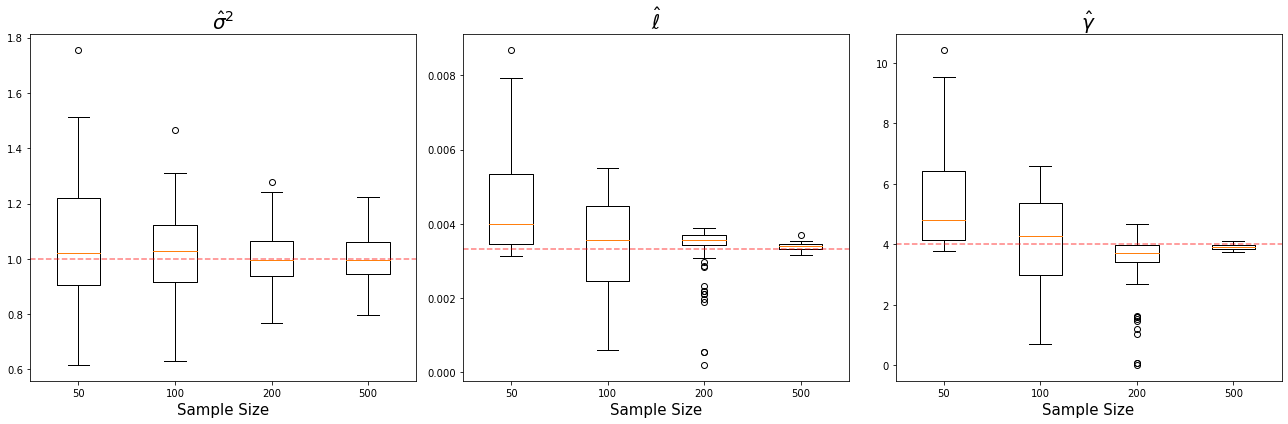

In [4]:
flattened_estimates = np.loadtxt('./results/periodic-simulation.txt')
param_estimates = flattened_estimates.reshape(len(true_params), len(sample_sizes), num_replicates).tolist()
param_names = [r'$\hat{\sigma}^2$', r'$\hat{\ell}$', r'$\hat{\gamma}$']
generate_boxplots(param_estimates, true_params, sample_sizes, param_names)

In [5]:
def check(n, params):
        kernel = construct_periodic_kernel(params)
        print(kernel)
        x = np.linspace(0, 1, n)
        K = kernel([[p] for p in x])
        eigvals = np.sort(np.linalg.eigvals(K))
        print(np.linalg.cond(K))
        print(eigvals)
    
n = 500
params = [1, 1/400, 2]
check(n, params)

1**2 * ExpSineSquared(length_scale=0.0025, periodicity=2)
1.1832311610850317
[0.91607909 0.91608403 0.91609228 0.91610383 0.91611867 0.91613681
 0.91615825 0.91618299 0.91621102 0.91624234 0.91627696 0.91631487
 0.91635606 0.91640055 0.91644832 0.91649938 0.91655372 0.91661134
 0.91667224 0.91673641 0.91680386 0.91687457 0.91694856 0.91702581
 0.91710632 0.9171901  0.91727712 0.9173674  0.91746093 0.9175577
 0.91765771 0.91776096 0.91786745 0.91797716 0.9180901  0.91820625
 0.91832563 0.91844821 0.918574   0.91870299 0.91883518 0.91897055
 0.91910912 0.91925086 0.91939578 0.91954386 0.91969511 0.91984952
 0.92000707 0.92016778 0.92033162 0.92049859 0.92066869 0.9208419
 0.92101823 0.92119767 0.9213802  0.92156582 0.92175453 0.92194631
 0.92214116 0.92233907 0.92254004 0.92274405 0.9229511  0.92316117
 0.92337427 0.92359038 0.9238095  0.92403161 0.9242567  0.92448478
 0.92471582 0.92494982 0.92518678 0.92542667 0.9256695  0.92591525
 0.92616391 0.92641547 0.92666993 0.92692727 0.9271874

In [6]:
y = [1, 2, 3, 4]
z = [3, 4, 2, 1]
v = np.transpose([y, z])
v.shape
v

array([[1, 3],
       [2, 4],
       [3, 2],
       [4, 1]])